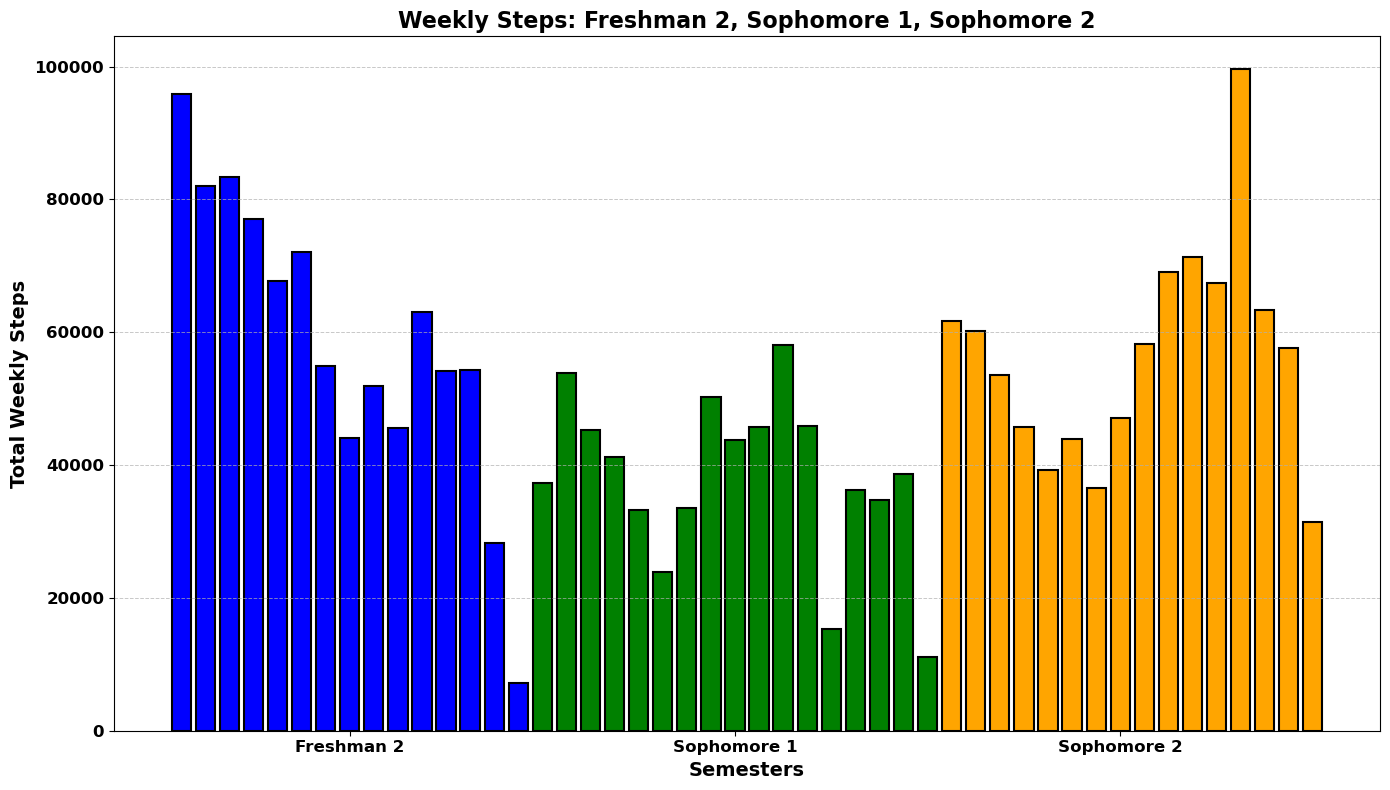

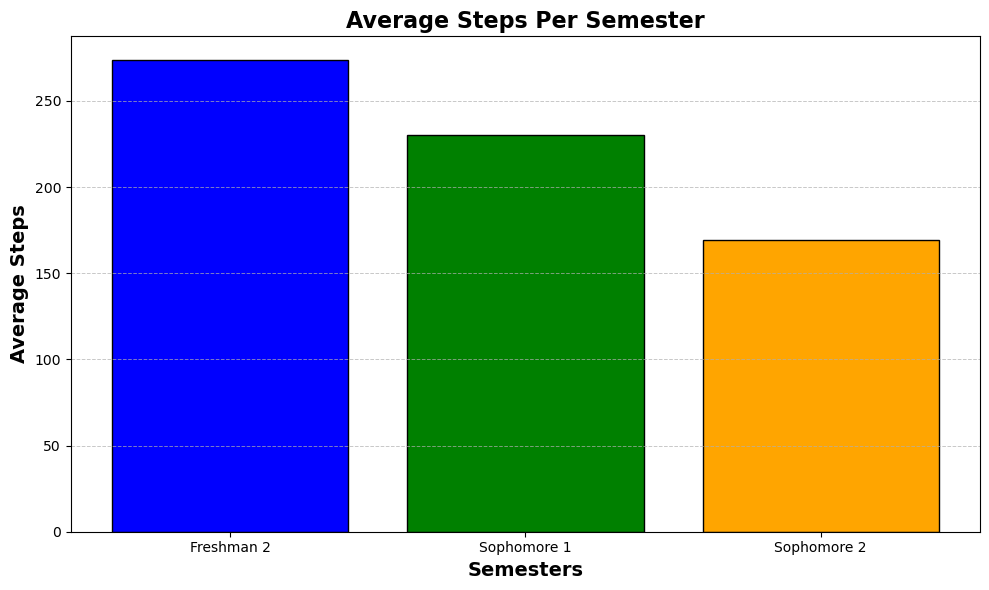

Hypothesis Testing Results:
T-Statistic: 1.770855720522017
P-Value: 0.09067974507583582
Reject the Null Hypothesis: There is a significant decrease in step count averages across semesters.


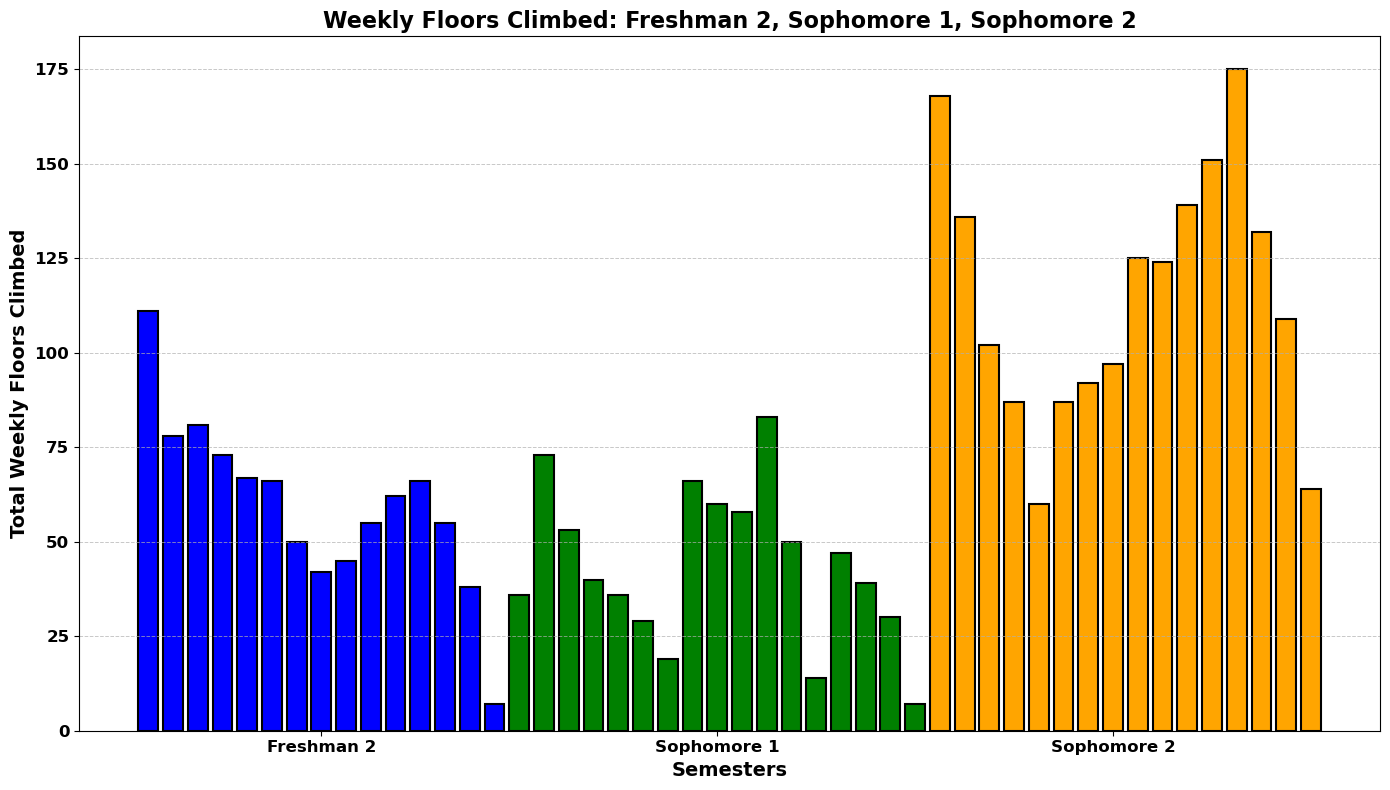

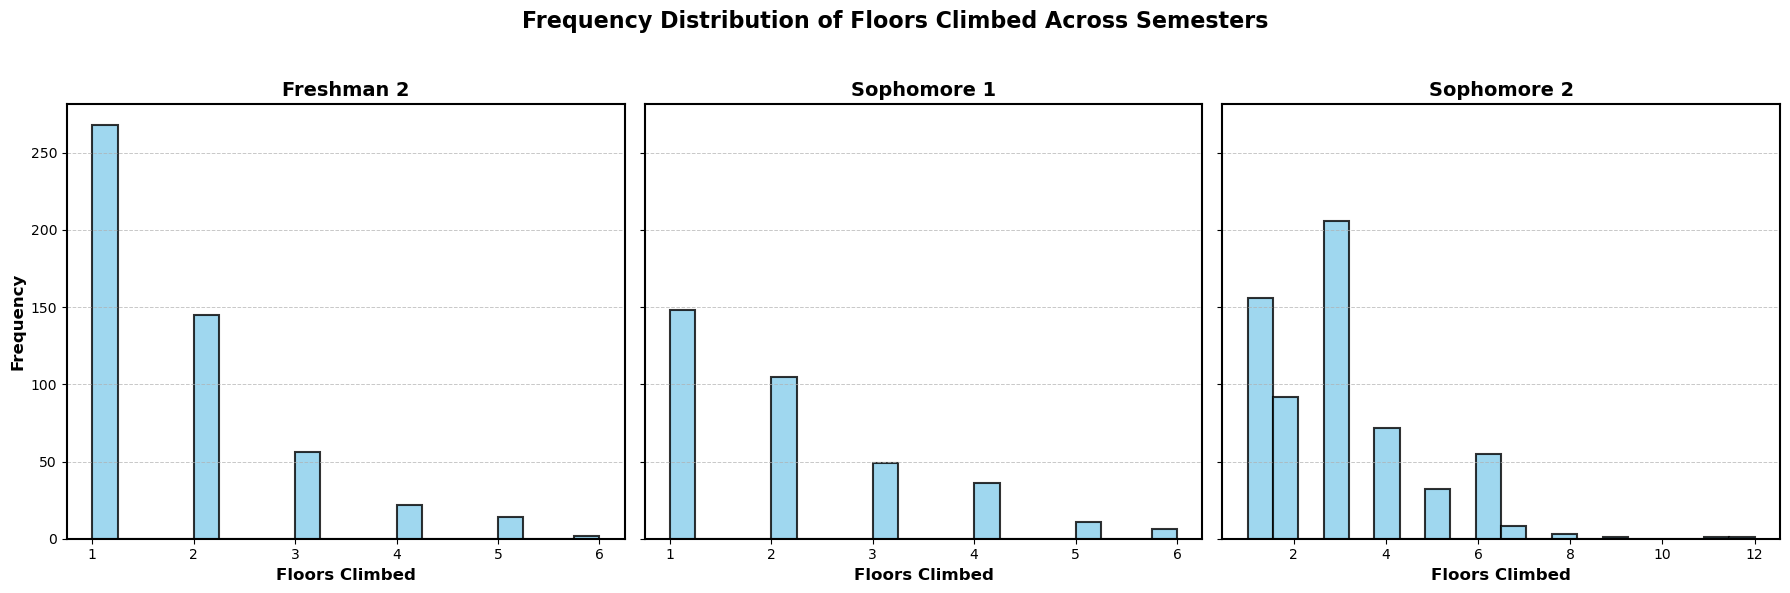

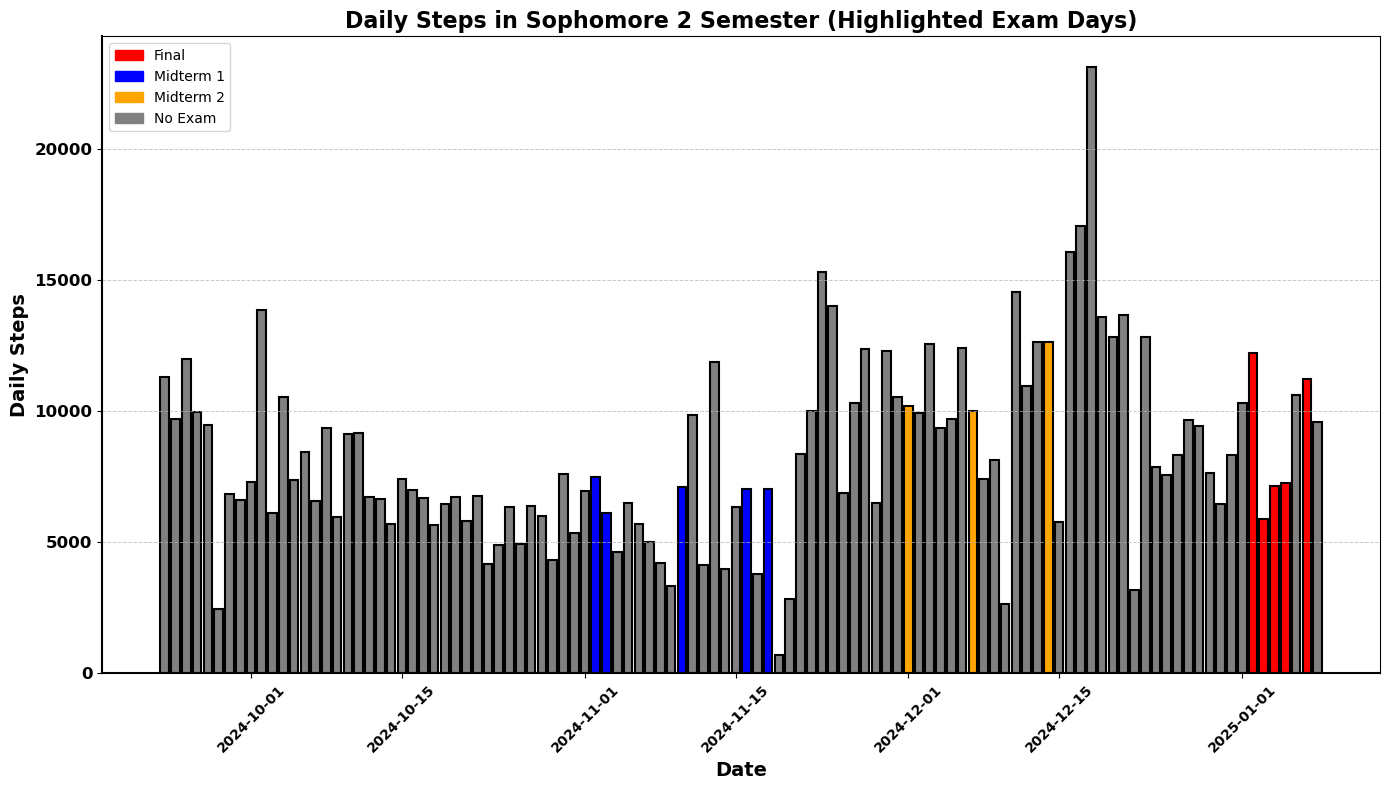

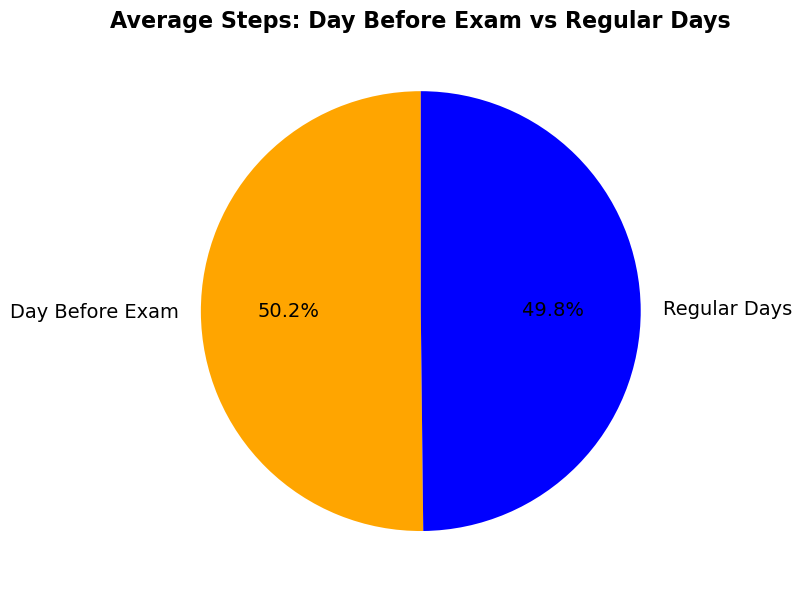

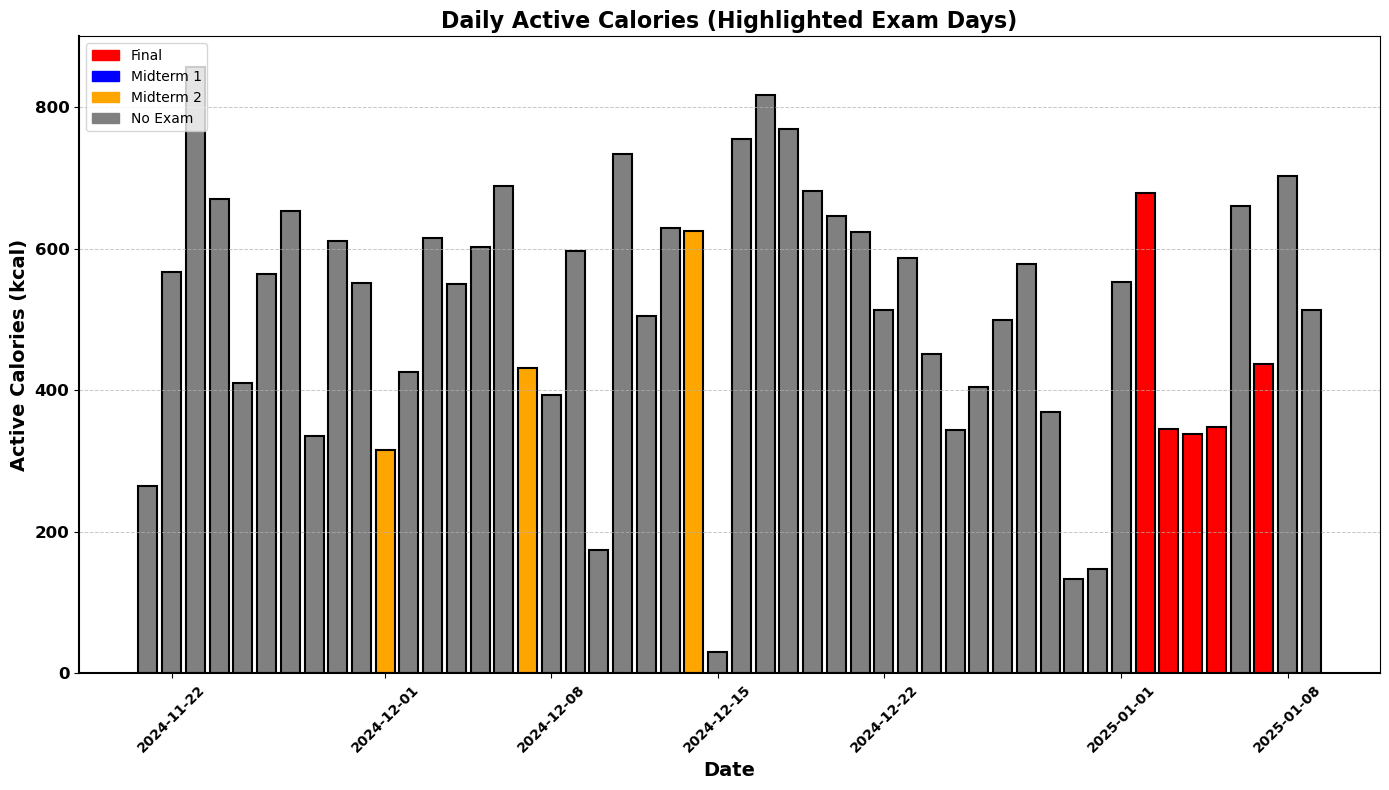

Hypothesis Testing Results:
T-Statistic: -1.5409640074749453
P-Value: 0.1470844043768611
Fail to Reject the Null Hypothesis: No significant difference in active calories on exam/midterm days and regular days.
Average Active Calories Burned:
Exam Days: 439.78 kcal
Non-Exam Days: 528.69 kcal


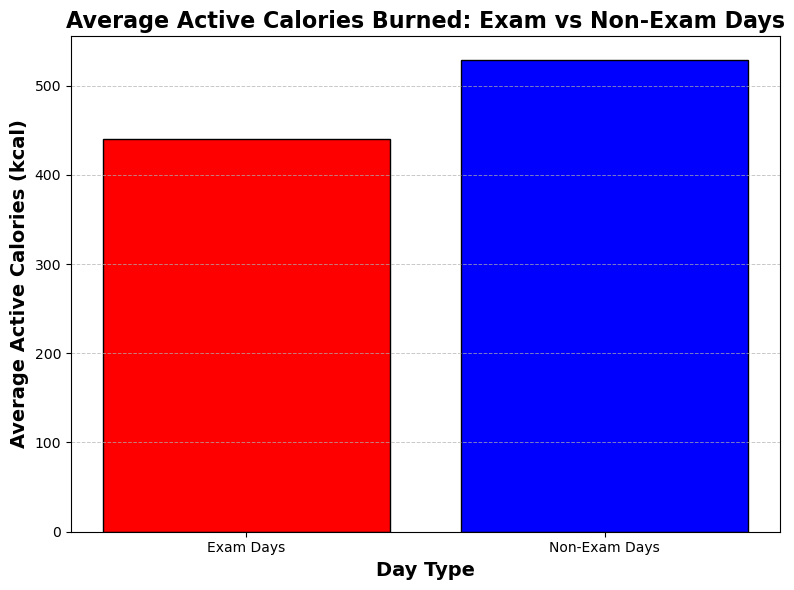

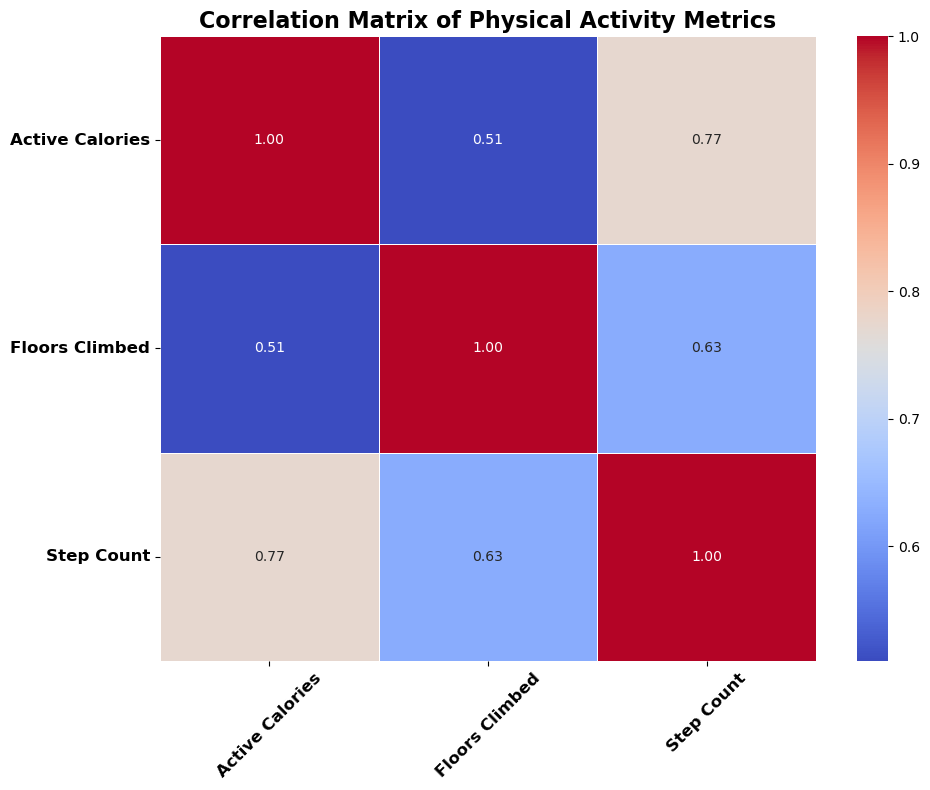

In [224]:



# first we import the necessary libraries

from bs4 import BeautifulSoup # for parsing the data
import pandas as pd
import matplotlib.pyplot as plt # for visualization and plots
from datetime import datetime
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches
import seaborn as sns # for correlation matrix







# Function to parse the XML file
def parse_health_data(file_path):
    # Read the XML file
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Parse the content using Beautiful Soup
    soup = BeautifulSoup(content, 'xml')

    # Initialize lists to store the data
    records = []

    # Extract records from the XML
    for record in soup.find_all('Record'):
        # Get attributes of interest
        record_type = record.get('type')
        start_date = record.get('startDate')
        end_date = record.get('endDate')
        value = record.get('value')

        # Append the data to the records list
        records.append({
            'type': record_type,
            'start_date': start_date,
            'end_date': end_date,
            'value': value
        })

    # Convert the list of records to a Pandas DataFrame
    data = pd.DataFrame(records)

    return data










# Here i have gathered some necessary dates that i will need for visualization and hypothesis testing

# Define semester date ranges
semesters = {
    "Freshman 2": (datetime(2023, 10, 2), datetime(2024, 1, 12)),
    "Sophomore 1": (datetime(2024, 2, 15), datetime(2024, 6, 5)),
    "Sophomore 2": (datetime(2024, 9, 23), datetime(2025, 1, 9))
}



# Define exam dates
exam_dates = {
    'Final': [
        datetime(2025, 1, 2).date(),
        datetime(2025, 1, 3).date(),
        datetime(2025, 1, 4).date(),
        datetime(2025, 1, 5).date(),
        datetime(2025, 1, 7).date()
    ],
    'Midterm 1': [
        datetime(2024, 11, 10).date(),
        datetime(2024, 11, 16).date(),
        datetime(2024, 11, 18).date(),
        datetime(2024, 11, 2).date(),
        datetime(2024, 11, 3).date()
    ],
    'Midterm 2': [
        datetime(2024, 12, 1).date(),
        datetime(2024, 12, 7).date(),
        datetime(2024, 12, 14).date()
    ]
}


sophomore2_range = (datetime(2024, 9, 23), datetime(2025, 1, 9))

# Define time range for active calories
active_calories_range = (datetime(2024, 11, 21), datetime(2025, 1, 9))














# Function to calculate weekly step averages and plot data
def plot_weekly_steps(data, semesters):
    # Filter for step count data
    step_data = data[data['type'].str.contains('StepCount', na=False)].copy()

    # Convert dates and values
    step_data['start_date'] = pd.to_datetime(step_data['start_date']).dt.tz_localize(None)
    step_data['value'] = pd.to_numeric(step_data['value'], errors='coerce')

    # Prepare data 
    all_weeks = []
    all_values = []
    all_labels = []

    # Process each semester
    for semester, (start_date, end_date) in semesters.items():
        # Ensure start_date and end_date are timezone-naive
        start_date = start_date.replace(tzinfo=None)
        end_date = end_date.replace(tzinfo=None)

        # Filter data for the semester
        mask = (step_data['start_date'] >= start_date) & (step_data['start_date'] <= end_date)
        semester_data = step_data.loc[mask].copy()  # Create a copy to avoid SettingWithCopyWarning

        # Group by week and calculate weekly total steps
        semester_data['week'] = semester_data['start_date'].dt.to_period('W')  # No warnings now
        weekly_totals = semester_data.groupby('week')['value'].sum()

        # Store weekly totals and labels
        all_weeks.extend(weekly_totals.index.astype(str))
        all_values.extend(weekly_totals.values)
        all_labels.extend([semester] * len(weekly_totals))

    # Plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(len(all_values)), all_values, color=['blue' if label == 'Freshman 2' else 'green' if label == 'Sophomore 1' else 'orange' for label in all_labels], edgecolor='black', linewidth=1.5)

    # Adjust labels to be centered under each semester's bars
    semester_positions = [
        (all_labels.index(semester), len(all_labels) - 1 - all_labels[::-1].index(semester))
        for semester in semesters.keys()
    ]
    semester_ticks = [(start + end) // 2 for start, end in semester_positions]
    plt.xticks(semester_ticks, semesters.keys(), rotation=0, fontsize=12, fontweight='bold')

    plt.xlabel('Semesters', fontsize=14, fontweight='bold')
    plt.ylabel('Total Weekly Steps', fontsize=14, fontweight='bold')
    plt.title('Weekly Steps: Freshman 2, Sophomore 1, Sophomore 2', fontsize=16, fontweight='bold')

    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    # Add frames around bars
    for bar in bars:
        bar.set_linewidth(1.5)
        bar.set_edgecolor('black')

    # Customize the ticks on the y-axis
    plt.yticks(fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()






def hypothesis_test(data, semesters):
    # Filter for step count data
    step_data = data[data['type'].str.contains('StepCount', na=False)].copy()

    # Convert dates and values
    step_data['start_date'] = pd.to_datetime(step_data['start_date']).dt.tz_localize(None)
    step_data['value'] = pd.to_numeric(step_data['value'], errors='coerce')

    # Prepare data for testing
    semester_averages = {}

    # Process each semester
    for semester, (start_date, end_date) in semesters.items():
        # Ensure start_date and end_date are timezone-naive
        start_date = start_date.replace(tzinfo=None)
        end_date = end_date.replace(tzinfo=None)

        # Filter data for the semester
        mask = (step_data['start_date'] >= start_date) & (step_data['start_date'] <= end_date)
        semester_data = step_data.loc[mask].copy()

        # Group by week and calculate weekly total steps
        semester_data['week'] = semester_data['start_date'].dt.to_period('W')
        weekly_totals = semester_data.groupby('week')['value'].sum()

        # Calculate average weekly steps for the semester
        semester_averages[semester] = weekly_totals

    # Perform hypothesis testing (two-sample t-test)
    freshman2 = semester_averages['Freshman 2']
    sophomore1 = semester_averages['Sophomore 1']
    sophomore2 = semester_averages['Sophomore 2']

    # Combine Sophomore 1 and Sophomore 2 for comparison with Freshman 2
    combined_sophomore = pd.concat([sophomore1, sophomore2])

    # Conduct t-test
    t_stat, p_value = ttest_ind(freshman2, combined_sophomore, equal_var=False)

    # Display the results
    print("Hypothesis Testing Results:")
    print(f"T-Statistic: {t_stat}")
    print(f"P-Value: {p_value}")

    if p_value < 0.10:
        print("Reject the Null Hypothesis: There is a significant decrease in step count averages across semesters.")
    else:
        print("Fail to Reject the Null Hypothesis: No significant decrease in step count averages across semesters.")









# Function to plot weekly floors climbed
def plot_weekly_floors(data, semesters):
    # Filter for floors climbed data
    floors_data = data[data['type'].str.contains('FlightsClimbed', na=False)].copy()

    # Convert dates and values
    floors_data['start_date'] = pd.to_datetime(floors_data['start_date']).dt.tz_localize(None)
    floors_data['value'] = pd.to_numeric(floors_data['value'], errors='coerce')

    # Prepare data for histogram
    all_weeks = []
    all_values = []
    all_labels = []

    # Process each semester
    for semester, (start_date, end_date) in semesters.items():
        # Ensure start_date and end_date are timezone-naive
        start_date = start_date.replace(tzinfo=None)
        end_date = end_date.replace(tzinfo=None)

        # Filter data for the semester
        mask = (floors_data['start_date'] >= start_date) & (floors_data['start_date'] <= end_date)
        semester_data = floors_data.loc[mask].copy()

        # Group by week and calculate weekly total floors climbed
        semester_data['week'] = semester_data['start_date'].dt.to_period('W')
        weekly_totals = semester_data.groupby('week')['value'].sum()

        # Store weekly totals and labels
        all_weeks.extend(weekly_totals.index.astype(str))
        all_values.extend(weekly_totals.values)
        all_labels.extend([semester] * len(weekly_totals))

    # Plot 
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(len(all_values)), all_values, color=['blue' if label == 'Freshman 2' else 'green' if label == 'Sophomore 1' else 'orange' for label in all_labels], edgecolor='black', linewidth=1.5)

    # Adjust labels to be centered under each semester's bars
    semester_positions = [
        (all_labels.index(semester), len(all_labels) - 1 - all_labels[::-1].index(semester))
        for semester in semesters.keys()
    ]
    semester_ticks = [(start + end) // 2 for start, end in semester_positions]
    plt.xticks(semester_ticks, semesters.keys(), rotation=0, fontsize=12, fontweight='bold')

    plt.xlabel('Semesters', fontsize=14, fontweight='bold')
    plt.ylabel('Total Weekly Floors Climbed', fontsize=14, fontweight='bold')
    plt.title('Weekly Floors Climbed: Freshman 2, Sophomore 1, Sophomore 2', fontsize=16, fontweight='bold')

    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    # Add frames around bars
    for bar in bars:
        bar.set_linewidth(1.5)
        bar.set_edgecolor('black')

    # Customize the ticks on the y-axis
    plt.yticks(fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()













# Function to plot daily average steps for Sophomore 2 and highlight exam days
def plot_daily_steps_with_exams(data, semester_range, exam_dates):
    # Filter for step count data
    step_data = data[data['type'].str.contains('StepCount', na=False)].copy()

    # Convert dates and values
    step_data['start_date'] = pd.to_datetime(step_data['start_date']).dt.tz_localize(None)
    step_data['value'] = pd.to_numeric(step_data['value'], errors='coerce')

    # Filter for Sophomore 2 semester
    mask = (step_data['start_date'] >= semester_range[0]) & (step_data['start_date'] <= semester_range[1])
    semester_data = step_data.loc[mask]

    # Group by day and calculate daily totals
    daily_totals = semester_data.groupby(semester_data['start_date'].dt.date)['value'].sum()

    # Create a color map for exams
    exam_colors = {
        'Final': 'red',
        'Midterm 1': 'blue',
        'Midterm 2': 'orange'
    }

    # Assign colors based on exam dates
    bar_colors = []
    for day in daily_totals.index:
        if day in exam_dates['Final']:
            bar_colors.append(exam_colors['Final'])
        elif day in exam_dates['Midterm 1']:
            bar_colors.append(exam_colors['Midterm 1'])
        elif day in exam_dates['Midterm 2']:
            bar_colors.append(exam_colors['Midterm 2'])
        else:
            bar_colors.append('gray')

    # Plot the daily steps
    plt.figure(figsize=(14, 8))
    bars = plt.bar(daily_totals.index, daily_totals.values, color=bar_colors, edgecolor='black', linewidth=1.5)

    plt.xlabel('Date', fontsize=14, fontweight='bold')
    plt.ylabel('Daily Steps', fontsize=14, fontweight='bold')
    plt.title('Daily Steps in Sophomore 2 Semester (Highlighted Exam Days)', fontsize=16, fontweight='bold')

    # Add a legend
    legend_patches = [
        mpatches.Patch(color='red', label='Final'),
        mpatches.Patch(color='blue', label='Midterm 1'),
        mpatches.Patch(color='orange', label='Midterm 2'),
        mpatches.Patch(color='gray', label='No Exam')
    ]
    plt.legend(handles=legend_patches, loc='upper left', fontsize=10, frameon=True)

    # Add gridlines for better visualization
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    # Enhance bar appearance
    for bar in bars:
        bar.set_linewidth(1.5)
        bar.set_edgecolor('black')

    # Add frames to the background
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)

    plt.xticks(rotation=45, fontsize=10, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()














# Function to plot daily active calories and highlight exam days
def plot_daily_active_calories(data, time_range, exam_dates):
    # Filter for active energy data
    active_data = data[data['type'].str.contains('ActiveEnergyBurned', na=False)].copy()

    # Convert dates and values
    active_data['start_date'] = pd.to_datetime(active_data['start_date']).dt.tz_localize(None)
    active_data['value'] = pd.to_numeric(active_data['value'], errors='coerce')

    # Filter for the specified time range
    mask = (active_data['start_date'] >= time_range[0]) & (active_data['start_date'] <= time_range[1])
    filtered_data = active_data.loc[mask]

    # Group by day and calculate daily totals
    daily_totals = filtered_data.groupby(filtered_data['start_date'].dt.date)['value'].sum()

    # Fill missing days with the average value
    all_days = pd.date_range(start=time_range[0], end=time_range[1], freq='D').date
    daily_totals = daily_totals.reindex(all_days, fill_value=daily_totals.mean())

    # Create a color map for exams
    exam_colors = {
        'Final': 'red',
        'Midterm 1': 'blue',
        'Midterm 2': 'orange'
    }

    # Assign colors based on exam dates
    bar_colors = []
    for day in daily_totals.index:
        if day in exam_dates['Final']:
            bar_colors.append(exam_colors['Final'])
        elif day in exam_dates['Midterm 1']:
            bar_colors.append(exam_colors['Midterm 1'])
        elif day in exam_dates['Midterm 2']:
            bar_colors.append(exam_colors['Midterm 2'])
        else:
            bar_colors.append('gray')

    # Plot the daily active calories
    plt.figure(figsize=(14, 8))
    bars = plt.bar(daily_totals.index, daily_totals.values, color=bar_colors, edgecolor='black', linewidth=1.5)

    plt.xlabel('Date', fontsize=14, fontweight='bold')
    plt.ylabel('Active Calories (kcal)', fontsize=14, fontweight='bold')
    plt.title('Daily Active Calories (Highlighted Exam Days)', fontsize=16, fontweight='bold')

    # Add a legend
    legend_patches = [
        mpatches.Patch(color='red', label='Final'),
        mpatches.Patch(color='blue', label='Midterm 1'),
        mpatches.Patch(color='orange', label='Midterm 2'),
        mpatches.Patch(color='gray', label='No Exam')
    ]
    plt.legend(handles=legend_patches, loc='upper left', fontsize=10, frameon=True)

    # Add gridlines for better visualization
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    # Enhance bar appearance
    for bar in bars:
        bar.set_linewidth(1.5)
        bar.set_edgecolor('black')

    # Add frames to the background
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)

    plt.xticks(rotation=45, fontsize=10, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()












# Function to test hypothesis: Is active calorie expenditure lower on exam/midterm days?
def hypothesis_test_active_calories_exam_days(data, time_range, exam_dates):
    # Filter for active energy data
    active_data = data[data['type'].str.contains('ActiveEnergyBurned', na=False)].copy()

    # Convert dates and values
    active_data['start_date'] = pd.to_datetime(active_data['start_date']).dt.tz_localize(None)
    active_data['value'] = pd.to_numeric(active_data['value'], errors='coerce')

    # Filter for the specified time range
    mask = (active_data['start_date'] >= time_range[0]) & (active_data['start_date'] <= time_range[1])
    filtered_data = active_data.loc[mask]

    # Group by day and calculate daily totals
    daily_totals = filtered_data.groupby(filtered_data['start_date'].dt.date)['value'].sum()

    # Identify exam/midterm days
    exam_days = []
    for category, dates in exam_dates.items():
        exam_days.extend(dates)

    # Separate active calories into exam/midterm days and regular days
    calories_exam_days = daily_totals[daily_totals.index.isin(exam_days)]
    calories_regular_days = daily_totals[~daily_totals.index.isin(exam_days)]

    # Perform hypothesis testing (two-sample t-test)
    t_stat, p_value = ttest_ind(calories_exam_days, calories_regular_days, equal_var=False, nan_policy='omit')

    # Display the results
    print("Hypothesis Testing Results:")
    print(f"T-Statistic: {t_stat}")
    print(f"P-Value: {p_value}")

    alpha = 0.10
    if p_value < alpha:
        print("Reject the Null Hypothesis: Active calories are significantly lower on exam/midterm days.")
    else:
        print("Fail to Reject the Null Hypothesis: No significant difference in active calories on exam/midterm days and regular days.")







def plot_correlation_matrix(data, time_range):
    # Define the types of interest
    types_of_interest = {
        'ActiveEnergyBurned': 'Active Calories',
        'FlightsClimbed': 'Floors Climbed',
        'StepCount': 'Step Count'
    }

    # Initialize a DataFrame to hold the aggregated data
    aggregated_data = pd.DataFrame()

    # Process each type of interest
    for record_type, column_name in types_of_interest.items():
        # Filter data for the specific type
        type_data = data[data['type'].str.contains(record_type, na=False)].copy()

        # Convert dates and values
        type_data['start_date'] = pd.to_datetime(type_data['start_date']).dt.tz_localize(None)
        type_data['value'] = pd.to_numeric(type_data['value'], errors='coerce')

        # Filter for the specified time range
        mask = (type_data['start_date'] >= time_range[0]) & (type_data['start_date'] <= time_range[1])
        filtered_data = type_data.loc[mask]

        # Group by day and calculate daily totals
        daily_totals = filtered_data.groupby(filtered_data['start_date'].dt.date)['value'].sum()

        # Fill missing days with the average value
        all_days = pd.date_range(start=time_range[0], end=time_range[1], freq='D').date
        daily_totals = daily_totals.reindex(all_days, fill_value=daily_totals.mean())

        # Add the aggregated data to the DataFrame
        aggregated_data[column_name] = daily_totals

    # Compute the correlation matrix
    correlation_matrix = aggregated_data.corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

    plt.title("Correlation Matrix of Physical Activity Metrics", fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold', rotation=45)
    plt.yticks(fontsize=12, fontweight='bold', rotation=0)
    plt.tight_layout()
    plt.show()






def average_calories_exam_vs_non_exam(data, time_range, exam_dates):

    # Filter for active energy data
    active_data = data[data['type'].str.contains('ActiveEnergyBurned', na=False)].copy()

    # Convert dates and values
    active_data['start_date'] = pd.to_datetime(active_data['start_date']).dt.tz_localize(None)
    active_data['value'] = pd.to_numeric(active_data['value'], errors='coerce')

    # Filter for the specified time range
    mask = (active_data['start_date'] >= time_range[0]) & (active_data['start_date'] <= time_range[1])
    filtered_data = active_data.loc[mask]

    # Group by day and calculate daily totals
    daily_totals = filtered_data.groupby(filtered_data['start_date'].dt.date)['value'].sum()

    # Identify exam/midterm days
    exam_days = []
    for category, dates in exam_dates.items():
        exam_days.extend(dates)

    # Separate active calories into exam/midterm days and regular days
    calories_exam_days = daily_totals[daily_totals.index.isin(exam_days)]
    calories_regular_days = daily_totals[~daily_totals.index.isin(exam_days)]

    # Calculate averages
    avg_exam_days = calories_exam_days.mean()
    avg_non_exam_days = calories_regular_days.mean()

    # Display the results
    print("Average Active Calories Burned:")
    print(f"Exam Days: {avg_exam_days:.2f} kcal")
    print(f"Non-Exam Days: {avg_non_exam_days:.2f} kcal")

    # Plot the averages
    categories = ['Exam Days', 'Non-Exam Days']
    averages = [avg_exam_days, avg_non_exam_days]

    plt.figure(figsize=(8, 6))
    plt.bar(categories, averages, color=['red', 'blue'], edgecolor='black')
    plt.xlabel('Day Type', fontsize=14, fontweight='bold')
    plt.ylabel('Average Active Calories (kcal)', fontsize=14, fontweight='bold')
    plt.title('Average Active Calories Burned: Exam vs Non-Exam Days', fontsize=16, fontweight='bold')
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.tight_layout()
    plt.show()

    return avg_exam_days, avg_non_exam_days






def average_steps_per_semester(data, semesters):
    import matplotlib.pyplot as plt

    # Filter for step count data
    step_data = data[data['type'].str.contains('StepCount', na=False)].copy()

    # Convert dates and values
    step_data['start_date'] = pd.to_datetime(step_data['start_date']).dt.tz_localize(None)
    step_data['value'] = pd.to_numeric(step_data['value'], errors='coerce')

    # Calculate average steps for each semester
    semester_averages = []
    semester_names = []

    for semester, (start_date, end_date) in semesters.items():
        mask = (step_data['start_date'] >= start_date) & (step_data['start_date'] <= end_date)
        semester_data = step_data.loc[mask]
        average_steps = semester_data['value'].mean()
        semester_averages.append(average_steps)
        semester_names.append(semester)

    # Plot the averages
    plt.figure(figsize=(10, 6))
    plt.bar(semester_names, semester_averages, color=['blue', 'green', 'orange'], edgecolor='black')
    plt.xlabel('Semesters', fontsize=14, fontweight='bold')
    plt.ylabel('Average Steps', fontsize=14, fontweight='bold')
    plt.title('Average Steps Per Semester', fontsize=16, fontweight='bold')
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.tight_layout()
    plt.show()

    return semester_averages






def pie_chart_average_steps_day_before_exam_vs_regular(data, semester_range, exam_dates):
    import matplotlib.pyplot as plt

    # Filter for step count data
    step_data = data[data['type'].str.contains('StepCount', na=False)].copy()

    # Convert dates and values
    step_data['start_date'] = pd.to_datetime(step_data['start_date']).dt.tz_localize(None)
    step_data['value'] = pd.to_numeric(step_data['value'], errors='coerce')

    # Filter for the specified semester range
    mask = (step_data['start_date'] >= semester_range[0]) & (step_data['start_date'] <= semester_range[1])
    filtered_data = step_data.loc[mask]

    # Group by day and calculate daily totals
    daily_totals = filtered_data.groupby(filtered_data['start_date'].dt.date)['value'].sum()

    # Identify days before exam days
    days_before_exam = [day - pd.Timedelta(days=1) for category, dates in exam_dates.items() for day in dates]

    # Separate steps into days before exams and regular days
    steps_day_before_exam = daily_totals[daily_totals.index.isin(days_before_exam)]
    steps_regular_days = daily_totals[~daily_totals.index.isin(days_before_exam)]

    # Calculate averages
    avg_steps_day_before_exam = steps_day_before_exam.mean()
    avg_steps_regular_days = steps_regular_days.mean()

    # Plot the pie chart
    labels = ['Day Before Exam', 'Regular Days']
    sizes = [avg_steps_day_before_exam, avg_steps_regular_days]
    colors = ['orange', 'blue']

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
    plt.title('Average Steps: Day Before Exam vs Regular Days', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return avg_steps_day_before_exam, avg_steps_regular_days





def frequency_distribution_floors_climbed(data, semesters):
    import matplotlib.pyplot as plt

    # Filter for floors climbed data
    floors_data = data[data['type'].str.contains('FlightsClimbed', na=False)].copy()

    # Convert dates and values
    floors_data['start_date'] = pd.to_datetime(floors_data['start_date']).dt.tz_localize(None)
    floors_data['value'] = pd.to_numeric(floors_data['value'], errors='coerce')

    # Prepare data for each semester
    all_semester_data = []
    all_labels = []

    for semester, (start_date, end_date) in semesters.items():
        mask = (floors_data['start_date'] >= start_date) & (floors_data['start_date'] <= end_date)
        semester_data = floors_data.loc[mask]['value'].dropna()
        all_semester_data.append(semester_data)
        all_labels.append(semester)

    # Create subplots for each semester
    fig, axes = plt.subplots(1, len(semesters), figsize=(18, 6), sharey=True)

    for i, ax in enumerate(axes):
        ax.hist(all_semester_data[i], bins=20, edgecolor='black', linewidth=1.5, alpha=0.8, color='skyblue')
        ax.set_title(all_labels[i], fontsize=14, fontweight='bold')
        ax.set_xlabel('Floors Climbed', fontsize=12, fontweight='bold')
        if i == 0:
            ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
        ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
        ax.spines['top'].set_linewidth(1.5)
        ax.spines['right'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)

    fig.suptitle('Frequency Distribution of Floors Climbed Across Semesters', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()










file_path = "C:\\Users\\Cabaroglu\\Desktop\\apple health data\\apple_health_data.xml"

# Parse the XML file
data = parse_health_data(file_path)






# Plot 
plot_weekly_steps(data, semesters)
average_steps_per_semester(data, semesters)
hypothesis_test(data, semesters)
plot_weekly_floors(data, semesters)
frequency_distribution_floors_climbed(data, semesters)

plot_daily_steps_with_exams(data, sophomore2_range, exam_dates)
pie_chart_average_steps_day_before_exam_vs_regular(data, (datetime(2024, 9, 23), datetime(2025, 1, 9)), exam_dates)


# Plot the daily active calories with exam highlights
plot_daily_active_calories(data, active_calories_range, exam_dates)


# Test hypothesis: Is active calorie expenditure lower on exam/midterm days?
hypothesis_test_active_calories_exam_days(data, active_calories_range, exam_dates)

# Call the function to calculate and display averages
average_calories_exam_vs_non_exam(data, active_calories_range, exam_dates)


# Define the time range
time_range = (datetime(2024, 11, 21), datetime(2025, 1, 9))

# Call the function to plot the correlation matrix
plot_correlation_matrix(data, time_range)





